In [1]:
import torch
import cvxpy as cp
import numpy as np
import scipy.sparse as spa
from cvxpylayers.torch import CvxpyLayer
import networkx as nx
import matplotlib.pyplot as plt
from utils import latexify

In [37]:
np.random.seed(0)

# generate problem data
n = 4   # nodes
k = 2   # suppliers (with prices p)
c = 2   # retail (with demand d)
m = 8   # links

supply_links = [0, 1]
retail_links = [6, 7]
internode_links = [2, 3, 4, 5]

# Incidence matrices (nodes x links)
A_in = np.array([[1, 0, 0, 0, 0, 0, 0, 0],   # 1 (supply)
                 [0, 1, 0, 0, 0, 0, 0, 0],   # 2 (supply)
                 [0, 0, 1, 0, 0, 1, 0, 0],   # 3 (retail)
                 [0, 0, 0, 1, 1, 0, 0, 0],   # 4 (retail)
                 ])

A_out = np.array([[0, 0, 1, 1, 0, 0, 0, 0],   # 1 (supply)
                  [0, 0, 0, 0, 1, 0, 0, 0],   # 2 (supply)
                  [0, 0, 0, 0, 0, 0, 1, 0],   # 3 (retail)
                  [0, 0, 0, 0, 0, 1, 0, 1],   # 4 (retail)
                  ])

# Prices
mu_p = torch.tensor([0, 0.1]).double()
sigma_p = torch.tensor([0.2, 0.2]).double()
mean_p = torch.exp(mu_p + sigma_p ** 2 /2).double().view(k, 1)
var_p = (torch.exp(sigma_p ** 2) - 1) * torch.exp(2 * mean_p + sigma_p ** 2)

# Demands
mu_d = torch.tensor([0.0, 0.4]).double()
sigma_d = torch.tensor([0.2, 0.2]).double()
mean_d = torch.exp(mu_d + sigma_d ** 2 /2).double().view(c, 1)
var_d = (torch.exp(sigma_d ** 2) - 1) * torch.exp(2 * mean_d + sigma_d ** 2)

# Uncertainty distribution (prices and demands)
w_dist = torch.distributions.log_normal.LogNormal(torch.cat([mu_p, mu_d], 0), 
                                                  torch.cat([sigma_p, sigma_d], 0))

# Capacities
h_max = 3. # Maximum capacity in every node
u_max = 2. # Link flow capacity

# Storage cost parameters, W(x) = alpha'x + beta'x^2 + gamma
alpha = 0.01
beta = 0.01

# Transportation cost parameters
tau = 0.05 * np.ones((m - k - c, 1))
tau_th = torch.tensor(tau, dtype=torch.double)
r = 1.3 * np.ones((k, 1))
r_th = torch.tensor(r, dtype=torch.double)


# Plotting settings
fig_width_pt = 469.75   # Get this from LaTeX using \the\textwidth
inches_per_pt = 1.0/72.27  # Convert pt to inch
fig_width = fig_width_pt * inches_per_pt

In [19]:
print(np.round(np.exp(0.1 + 0.04/2), decimals=2))
print(np.round(np.exp(0.0 +  0.04/2), decimals=2))
print(np.round(np.exp(0.4 +  0.04/2), decimals=2))

1.13
1.02
1.52


In [4]:
print(w_dist.sample())
print(mean_p)
print(var_p)
print(mean_d)
print(var_d)

tensor([0.8140, 1.1559, 0.9484, 1.2243], dtype=torch.float64)
tensor([[1.0202],
        [1.1275]], dtype=torch.float64)
tensor([[0.3268, 0.3268],
        [0.4050, 0.4050]], dtype=torch.float64)
tensor([[1.0202],
        [1.5220]], dtype=torch.float64)
tensor([[0.3268, 0.3268],
        [0.8915, 0.8915]], dtype=torch.float64)


In [5]:
# Define linear dynamics
# x = (h, p^{wh}, d) 
# u = u
# w = (p^{wh}, d)
# x_{t+1} = Ax_{t} + Bu_{t} + w
A_d = np.bmat([[np.eye(n), np.zeros((n, k+c))],
              [np.zeros((k+c, n)), np.zeros((k+c, k+c))]])
A_d_th = torch.tensor(A_d, dtype=torch.double)
B_d = np.vstack([A_in - A_out,
                 np.zeros((k+c, m))])
B_d_th = torch.tensor(B_d, dtype=torch.double)
n_x, n_u = B_d.shape

In [6]:
# Setup policy
# Parameters
P_sqrt = cp.Parameter((n, n))
q = cp.Parameter((n, 1))
x = cp.Parameter((n_x, 1))
h, p, d = x[:n], x[n:n+k], x[n+k:]

# Variables
u = cp.Variable((n_u, 1))
h_next = cp.Variable((n, 1))

# Cvxpy Layer
stage_cost = cp.vstack([p, tau, -r]).T @ u
next_stage_cost = cp.sum_squares(P_sqrt @ h_next) + q.T @ h_next
constraints = [h_next == h + (A_in - A_out) @ u, 
               h_next <= h_max,  
               0 <= u, u <= u_max,
               A_out @ u <= h, u[retail_links] <= d,
              ]
prob = cp.Problem(cp.Minimize(stage_cost + next_stage_cost), constraints)
policy = CvxpyLayer(prob, [x, P_sqrt, q], [u])

In [7]:
def stage_cost(x, u):
    assert x.shape[0] == u.shape[0]
    batch_size = x.shape[0]
    r_batch = r_th.repeat(batch_size, 1, 1)
    tau_batch = tau_th.repeat(batch_size, 1, 1)
    
    h, p, dh = x[:,:n], x[:, n:n+k], x[:, n+k:]
    
    m = len(u)    
    
    # Selling + buying + shipping cost
    s_vec = torch.cat([p, tau_batch, -r_batch], 1).double()
    S = torch.bmm(s_vec.transpose(1, 2), u)
    H = alpha * h + beta * (h ** 2)  # Storage cost
        
    return torch.sum(S, 1) + torch.sum(H, 1)

def simulate(x, u):
    assert x.shape[0] == u.shape[0]
    batch_size = x.shape[0]

    A_batch = A_d_th.repeat(batch_size, 1, 1)
    B_batch = B_d_th.repeat(batch_size, 1, 1)
    
    zer = torch.zeros(batch_size, n, 1).double()
    w = w_dist.sample((batch_size,)).double().view((batch_size, k + c, 1))
    w_batch = torch.cat([zer, w], 1).double()
    
    return torch.bmm(A_batch, x) + torch.bmm(B_batch, u) + w_batch

    
def loss(policy, params, time_horizon, batch_size=1, seed=None):
    P_sqrt, q = params
    if seed is not None:
        torch.manual_seed(seed)
        
    # Batchify input
    x_b_0 = h_max * torch.rand(batch_size, n, 1).double()
    w_0 = w_dist.sample((batch_size,)).double().view((batch_size, k+c, 1))
    x_batch = torch.cat([x_b_0, w_0], 1).double()

    # Repeat parameter values
    P_sqrt_batch = P_sqrt.repeat(batch_size, 1, 1)
    q_batch = q.repeat(batch_size, 1, 1)

    cost = 0.0
    x_t = x_batch
    x_hist = [x_batch]
    u_hist = []
    for t in range(time_horizon):
        u_t = policy(x_t, P_sqrt_batch, q_batch, solver_args={"acceleration_lookback": 0})[0]
        x_t = simulate(x_t, u_t) 
        cost += stage_cost(x_t, u_t).mean() / time_horizon
        x_hist.append(x_t)
        u_hist.append(u_t)
        
    return cost, x_hist, u_hist


def monte_carlo(policy, params, time_horizon, batch_size=1, trials=10, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    results = []
    x = []
    u = []
    
    for i in range(trials):
        cost, x_hist, u_hist = loss(policy, params, time_horizon, batch_size=batch_size, seed=seed)
        results.append(cost.item())
        x.append(x_hist)
        u.append(u_hist)
    return results, x, u


In [8]:
def train(policy, params, time_horizon, lr, epochs, batch_size):
    opt = torch.optim.SGD(params, lr=lr)
    val_costs = []
    best_params = []
            
    for epoch in range(epochs):
        with torch.no_grad():
            val_cost_mc, x_behav, u_behav = monte_carlo(policy, params, time_horizon, 1, trials=10, seed=0)
            val_cost = np.mean(val_cost_mc)
            val_costs.append(val_cost)

        torch.manual_seed(epoch)
        opt.zero_grad()
        cost, _, _,  = loss(policy, params, time_horizon, batch_size, seed=epoch+1)
        cost.backward()
        print("epoch %d, valid %.4e" % (epoch, val_cost))         
        # TODO: Print gradient norm (possibly clip it)
        # torch.nn.utils.clip_grad_norm_(params, 1)
#         for p in params:
#             print(p.grad.data.norm(2).item())
        opt.step()
#         scheduler.step(val_cost)        
    return val_costs, [np.array(p.detach().numpy()) for p in params], x_behav, u_behav

In [9]:
# Perform training
time_horizon = 20
epochs = 200
batch_size = 5
lr = 0.05

# Initialize value function V(x) = x'Px + q'x
# centered at h_max/2 (between 0 and h_max) of each node
torch.manual_seed(0)
P_sqrt = torch.eye(n, requires_grad=True, dtype=torch.double)
q = -h_max * torch.ones(n, 1, dtype=torch.double)
# P_sqrt = torch.zeros(n, n).double()
# q = torch.zeros((n, 1)).double()
q.requires_grad_(True)
params = [P_sqrt, q]

# Baseline
P_sqrt_baseline = torch.eye(n, dtype=torch.double)
q_baseline = -h_max * torch.ones(n, 1, dtype=torch.double)
# P_sqrt_baseline = torch.zeros(n, n).double()
# q_baseline = torch.zeros((n, 1)).double()
baseline_params = [P_sqrt_baseline, q_baseline]
baseline_costs, x_behav_bl, u_behav_bl = monte_carlo(policy, baseline_params, time_horizon, batch_size=1, trials=10, seed=0)
baseline_cost = np.mean(baseline_costs)
print("Baseline cost: ", baseline_cost)

print("Perform training")
val_cost, params, x_behav, u_behav = train(policy, params, time_horizon, lr, epochs, batch_size)
print("Final cost: ", val_cost[-1])

improvement = 100 * np.abs(baseline_cost - val_cost[-1])/np.abs(baseline_cost)
print("Performance improvement: %.2f %% over baseline cost" %  improvement)

# Store final values
P_sqrt_train = P_sqrt.detach().numpy()
q_train = q.detach().numpy()

Baseline cost:  -0.2786436537604188
Perform training
epoch 0, valid -2.7864e-01
epoch 1, valid -2.8086e-01
epoch 2, valid -2.8249e-01
epoch 3, valid -2.8470e-01
epoch 4, valid -2.8614e-01
epoch 5, valid -2.8761e-01
epoch 6, valid -2.8670e-01
epoch 7, valid -2.9183e-01


/Users/sidereus/miniconda3/envs/python37/lib/python3.7/site-packages/diffcp/cone_program.py:259: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")


epoch 8, valid -2.9450e-01
epoch 9, valid -2.9483e-01
epoch 10, valid -2.9606e-01
epoch 11, valid -3.0273e-01
epoch 12, valid -3.0218e-01
epoch 13, valid -3.0280e-01
epoch 14, valid -3.0113e-01
epoch 15, valid -3.0609e-01
epoch 16, valid -3.0719e-01
epoch 17, valid -3.0744e-01
epoch 18, valid -3.0588e-01
epoch 19, valid -3.0885e-01
epoch 20, valid -3.1254e-01
epoch 21, valid -3.1304e-01
epoch 22, valid -3.1392e-01
epoch 23, valid -3.1485e-01
epoch 24, valid -3.1601e-01
epoch 25, valid -3.1466e-01
epoch 26, valid -3.1662e-01
epoch 27, valid -3.1747e-01
epoch 28, valid -3.1957e-01
epoch 29, valid -3.2224e-01
epoch 30, valid -3.2307e-01
epoch 31, valid -3.2327e-01
epoch 32, valid -3.2457e-01
epoch 33, valid -3.2553e-01
epoch 34, valid -3.2729e-01
epoch 35, valid -3.2815e-01
epoch 36, valid -3.2954e-01
epoch 37, valid -3.2963e-01
epoch 38, valid -3.3178e-01
epoch 39, valid -3.3258e-01
epoch 40, valid -3.3211e-01
epoch 41, valid -3.3208e-01
epoch 42, valid -3.3302e-01
epoch 43, valid -3.343

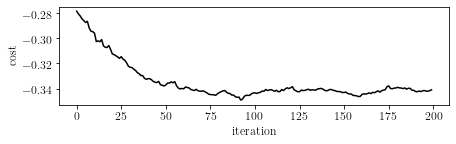

In [38]:
latexify(fig_width=fig_width, fig_height=fig_width/3, columns=2)
plt.plot(val_cost, c='k', label="Loss")
plt.xlabel('iteration')
plt.ylabel('cost')
plt.tight_layout()
plt.savefig("supply_chain_training.pdf")
plt.show()

In [24]:
print(np.round(P_sqrt_train.T.dot(P_sqrt_train), decimals=2))
print(np.round(q_train, decimals=2))
def bmatrix(a):
    """Returns a LaTeX bmatrix

    :a: numpy array
    :returns: LaTeX bmatrix as a string
    """
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{bmatrix}']
    return '\n'.join(rv)
print(bmatrix(np.round(P_sqrt_train.T.dot(P_sqrt_train), decimals=2)))
print(bmatrix(np.round(q_train.T, decimals=2)))

[[ 0.64  0.3   0.02 -0.06]
 [ 0.3   1.44  0.32  0.3 ]
 [ 0.02  0.32  1.14  0.06]
 [-0.06  0.3   0.06  1.01]]
[[-3.05]
 [-2.92]
 [-2.97]
 [-2.99]]
\begin{bmatrix}
  0.64 & 0.3 & 0.02 & -0.06\\
  0.3 & 1.44 & 0.32 & 0.3\\
  0.02 & 0.32 & 1.14 & 0.06\\
  -0.06 & 0.3 & 0.06 & 1.01\\
\end{bmatrix}
\begin{bmatrix}
  -3.05 & -2.92 & -2.97 & -2.99\\
\end{bmatrix}


In [12]:
print(P_sqrt_baseline.numpy().T.dot(P_sqrt_baseline.numpy()))
print(q_baseline.numpy())

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[-3.]
 [-3.]
 [-3.]
 [-3.]]


In [13]:
# Mean values over episodes
n_episodes = len(u_behav)
u_print = np.sum([np.vstack([u.detach().numpy().flatten() for u in u_b]) for u_b in u_behav], 0)/n_episodes
x_print = np.sum([np.vstack([x.detach().numpy().flatten() for x in x_b]) for x_b in x_behav], 0)/n_episodes
u_print_bl = np.sum([np.vstack([u.detach().numpy().flatten() for u in u_b]) for u_b in u_behav_bl], 0)/n_episodes
x_print_bl = np.sum([np.vstack([u.detach().numpy().flatten() for u in x_b]) for x_b in x_behav_bl], 0)/n_episodes

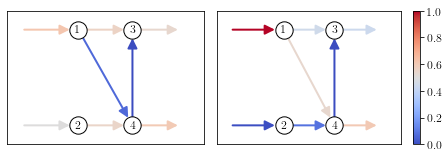

In [41]:
# Add wharehouse and store nodes (to plot edges)
A_in_g = np.vstack([[0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0], 
                    A_in,
                    [0, 0, 0, 0, 0, 0, 1, 0],
                    [0, 0, 0, 0, 0, 0, 0, 1]])
A_out_g = np.vstack([[1, 0, 0, 0, 0, 0, 0, 0],
                     [0, 1, 0, 0, 0, 0, 0, 0], 
                     A_out,
                     [0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0]])


def draw_policy(ax, u_draw, plot_title, max_norm=None, fig_width=None, fig_height=None, print_colorbar=True):
    # Create graph
    DG = nx.DiGraph()
    DG.add_nodes_from(range(n + k + c))

    weights = np.sum(u_draw, axis=0)
    if max_norm is None:
        weights /= np.max(weights)
    else:
        weights /= max_norm
        
    for z in range(m):
        i = np.where(A_out_g[:, z] == 1)[0]
        j = np.where(A_in_g[:, z] == 1)[0]
        # Check if they are not empty
        if len(i) > 0 and len(j) > 0:
            DG.add_edge(i[0], j[0], weight=weights[z])

    # Layout
    layout = {0: np.array([0.0, 0.5]),
              1: np.array([0.0, 0.0]),
              2: np.array([1.0, 0.5]),
              3: np.array([1.0, 0.0]),
              4: np.array([2.0, 0.5]),
              5: np.array([2.0, 0.0]),
              6: np.array([3.0, 0.5]),
              7: np.array([3.0, 0.0])
             }
    # Labels
    labels = {0: "",
          1: "",
          2: "1",
          3: "2",
          4: "3",
          5: "4",
          6: "",
          7: ""}
    node_color = ['red'] * k + ['blue'] * n + ['green'] * c
    edges, edge_color = zip(*nx.get_edge_attributes(DG,'weight').items())
    nodes = DG.nodes()
    plt.sca(ax)
    cmap = plt.cm.coolwarm
#     cmap = plt.cm.Greys
#     nx.draw_networkx_nodes(DG, layout, 
#                            node_color='k',
#                            nodelist=[0,1],
#                            node_shape='s')
    nx.draw_networkx_nodes(DG, layout, 
                           node_color='w',
                           edgecolors='k',
                           nodelist=range(2, 6),
                           node_shape='o')
#     nx.draw_networkx_nodes(DG, layout, 
#                            node_color='k',
#                            nodelist=[6, 7],
#                            node_shape='^')
    nx.draw_networkx_labels(DG, layout, labels=labels)
    ec = nx.draw_networkx_edges(DG, layout, 
                                edge_cmap=cmap, 
                                edge_color=edge_color, 
                                edgelist=edges,
                                edge_vmin=0,
                                edge_vmax=1,
                                arrowsize=20, width=2)

    # Plot colorbar
    if print_colorbar:
        sm = plt.cm.ScalarMappable(cmap=cmap, 
                                   norm=plt.Normalize(vmin=0., vmax=1.0)
                                  )
        cbar = plt.colorbar(sm)
#     plt.title(plot_title)
    

latexify(fig_width=fig_width, fig_height=fig_width/2.75)
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [0.85, 1]})



# Maximum order u between baseline and tuned
max_norm = np.maximum(np.max(np.sum(u_print, axis=0)), np.max(np.sum(u_print_bl, axis=0)))

draw_policy(ax1, u_print_bl, "Untuned policy", 
            max_norm=max_norm, 
            print_colorbar=False)
draw_policy(ax2, u_print, "Tuned policy", 
            max_norm=max_norm, 
            print_colorbar=True)
plt.tight_layout()
plt.savefig("supply_chain_policies.pdf")

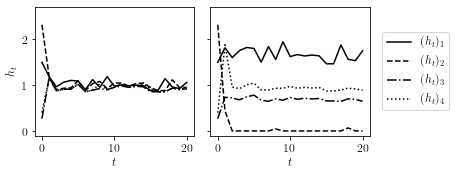

In [42]:
latexify(fig_width=fig_width, fig_height=fig_width/2.5)
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)


# # Loss function
# ax1.plot(val_cost, c='k', label="Loss")
# ax1.set_xlabel('iteration')
# ax1.set_ylabel('cost')


# Storage
ax1.plot(x_print_bl[:, 0], c='k', label="$(h_t)_1$")
ax1.plot(x_print_bl[:, 1], linestyle="--", c='k', label="$(h_t)_2$")
ax1.plot(x_print_bl[:, 2], linestyle="-.", c='k', label="$(h_t)_3$")
ax1.plot(x_print_bl[:, 3], linestyle=":",c='k', label="$(h_t)_4$")
# ax3.legend()
ax1.set_ylim([-0.1, 2.7])
ax1.set_xlabel("$t$")
ax1.set_ylabel('$h_t$')
# ax1.set_title("Untuned policy")


# Storage
ax2.plot(x_print[:, 0], c='k', label="$(h_t)_1$")
ax2.plot(x_print[:, 1], linestyle="--", c='k', label="$(h_t)_2$")
ax2.plot(x_print[:, 2], linestyle="-.", c='k', label="$(h_t)_3$")
ax2.plot(x_print[:, 3], linestyle=":",c='k', label="$(h_t)_4$")
# ax2.legend()
ax2.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
ax2.set_ylim([-0.1, 2.7])
ax2.set_xlabel("$t$")
# ax2.set_ylabel('$h_t$')
# ax2.set_title("Tuned policy")

plt.tight_layout()
plt.savefig("supply_chain_storage.pdf")
plt.show()